imports

In [ ]:
!pip install ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 7.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
import ijson
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data loading

In [ ]:
file_path = "quotes.json"

In [ ]:
def count_quotes(file_path):
    with open(file_path, 'r') as f:
        return sum(1 for _ in ijson.items(f, 'item'))

In [ ]:
def load_quotes_in_batches(file_path, batch_size=64):
    with open(file_path, 'r') as f:
        objects = ijson.items(f, 'item')
        current_batch = []
        for i, obj in enumerate(objects):
            current_batch.append(obj['Quote'])
            if (i + 1) % batch_size == 0:
                yield current_batch
                current_batch = []
        if current_batch:
            yield current_batch


generator to prepare data in batches

In [ ]:
def data_generator_from_list(quotes_list, tokenizer, seq_length, batch_size):
    num_quotes = len(quotes_list)
    while True:
        for i in range(0, num_quotes, batch_size):
            batch = quotes_list[i:i + batch_size]
            text = ' '.join(batch)
            sequences = tokenizer.texts_to_sequences([text])[0]
            X, y = [], []
            for j in range(0, len(sequences) - seq_length):
                X.append(sequences[j:j + seq_length])
                y.append(sequences[j + seq_length])
            X = np.array(X)
            y = tf.keras.utils.to_categorical(y, num_classes=len(tokenizer.word_index) + 1)
            yield X, y

In [ ]:
print("Counting total quotes...")
total_quotes = count_quotes(file_path)
print(f"Total quotes in dataset: {total_quotes}")

Counting total quotes...
Total quotes in dataset: 48391


tokenizer

In [ ]:
tokenizer = Tokenizer(char_level=True)
for batch in load_quotes_in_batches(file_path, batch_size=500):
    tokenizer.fit_on_texts(batch)
total_chars = len(tokenizer.word_index)
print(f"Total unique characters: {total_chars}")

Total unique characters: 494


model setup

In [ ]:
seq_length = 40
model = Sequential([
    Embedding(input_dim=total_chars + 1, output_dim=32, input_length=seq_length),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(total_chars + 1, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

generator prep

In [ ]:
batch_size = 64
steps_per_epoch = count_quotes(file_path) // batch_size

# Load all quotes into a list
all_quotes = []
for batch in load_quotes_in_batches(file_path, batch_size=250):
    all_quotes.extend(batch)

# Split the data into training and validation sets
train_quotes, val_quotes = train_test_split(all_quotes, test_size=0.2, random_state=42)

train_generator = data_generator_from_list(train_quotes, tokenizer, seq_length, batch_size)
val_generator = data_generator_from_list(val_quotes, tokenizer, seq_length, batch_size)
steps_per_epoch_val = len(val_quotes) // batch_size

print("Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=val_generator,
    validation_steps=steps_per_epoch_val
)



Starting training...
Epoch 1/5
756/756 ━━━━━━━━━━━━━━━━━━━━ 4342s 6s/step - accuracy: 0.4549 - loss: 1.8522 - val_accuracy: 0.4915 - val_loss: 1.7180
Epoch 2/5
756/756 ━━━━━━━━━━━━━━━━━━━━ 4271s 6s/step - accuracy: 0.4747 - loss: 1.7819 - val_accuracy: 0.5085 - val_loss: 1.6594
Epoch 3/5
756/756 ━━━━━━━━━━━━━━━━━━━━ 4296s 6s/step - accuracy: 0.4887 - loss: 1.7318 - val_accuracy: 0.5195 - val_loss: 1.6177
Epoch 4/5
756/756 ━━━━━━━━━━━━━━━━━━━━ 4340s 6s/step - accuracy: 0.4997 - loss: 1.6896 - val_accuracy: 0.5289 - val_loss: 1.5846
Epoch 5/5
756/756 ━━━━━━━━━━━━━━━━━━━━ 4288s 6s/step - accuracy: 0.5077 - loss: 1.6584 - val_accuracy: 0.5367 - val_loss: 1.5608


saving the model

In [18]:
model.save("lstm_quotes_model.h5")
print("Model saved successfully!")

Model saved successfully!


evaluation of the model

In [19]:
print("Evaluating the model on the validation set...")
loss, accuracy = model.evaluate(val_generator, steps=steps_per_epoch_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

Evaluating the model on the validation set...
151/151 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.5370 - loss: 1.5602
Validation Loss: 1.5610, Validation Accuracy: 0.5367


visualizing

Visualizing training progress...


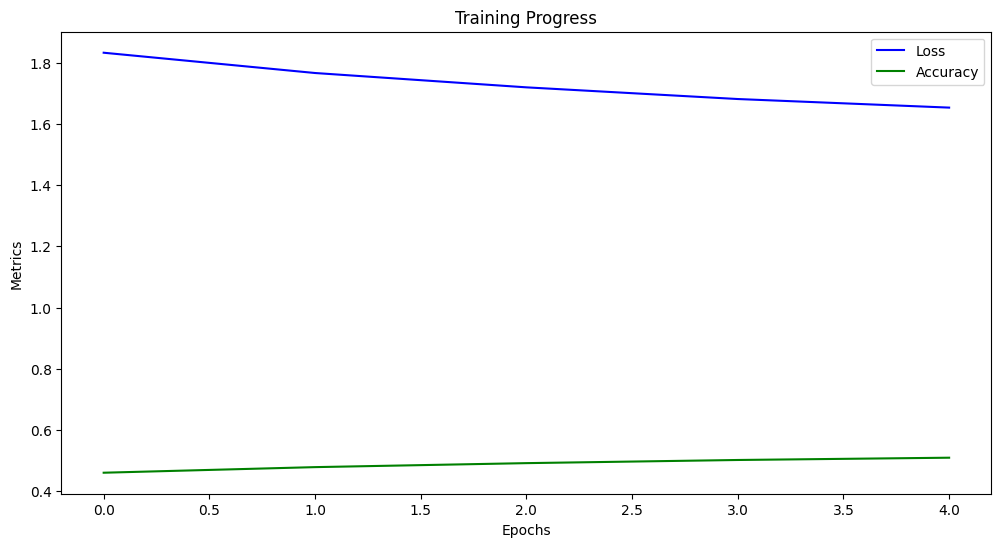

In [20]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Loss', color='blue')
    plt.plot(history.history['accuracy'], label='Accuracy', color='green')
    plt.title('Training Progress')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

print("Visualizing training progress...")
plot_training_history(history)

finally text generation

In [22]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_text(model, tokenizer, seed_text, seq_length, num_chars):
    """Generate text using the trained LSTM model."""
    generated_text = seed_text
    for _ in range(num_chars):
        # Tokenize the input text
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = pad_sequences([token_list], maxlen=seq_length, padding='pre')

        # Predict the next character
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=-1)[0]

        # Convert the index back to the character
        output_char = tokenizer.index_word.get(predicted_index, '')
        if output_char == '':  # Stop if no valid character is found
            break

        # Append the predicted character to the text
        generated_text += output_char

    return generated_text

# Load the trained model
model = load_model("lstm_quotes_model.h5")

# Generate text
seed_text = "Life is"
seq_length = 40  # Same as the training sequence length
num_chars = 200  # Number of characters to generate

print("Generating text...")
generated_text = generate_text(model, tokenizer, seed_text, seq_length, num_chars)
print("Generated text:")
print(generated_text)


Generating text...
Generated text:
Life is the start of the start of the start of the start of the start of the start of the start of the start of the start of the start of the start of the start of the start of the start of the start of the 
